In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

import warnings
warnings.filterwarnings('ignore')

In [2]:
motorbike_df = pd.read_csv("data/motorbike_updated.csv")
motorbike_df

,index,date,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,day_night
0,1,2011-01-01,0,0,1,0,0,6,0,1,0.24,0.81,0.0000,16,0
1,2,2011-01-01,0,0,1,1,0,6,0,1,0.22,0.80,0.0000,40,0
2,3,2011-01-01,0,0,1,2,0,6,0,1,0.22,0.80,0.0000,32,0
3,4,2011-01-01,0,0,1,3,0,6,0,1,0.24,0.75,0.0000,13,0
4,5,2011-01-01,0,0,1,4,0,6,0,1,0.24,0.75,0.0000,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,0,1,12,19,0,1,1,2,0.26,0.60,0.1642,119,1
17375,17376,2012-12-31,0,1,12,20,0,1,1,2,0.26,0.60,0.1642,89,1
17376,17377,2012-12-31,0,1,12,21,0,1,1,1,0.26,0.60,0.1642,90,1
17377,17378,2012-12-31,0,1,12,22,0,1,1,1,0.26,0.56,0.1343,61,0


So, from previous analysis, we have found some interesting places where anomalies can possibly be. Now we are gonna detect them.

In [3]:
motorbike_df["cnt"].max()

977

In [4]:
motorbike_df.loc[motorbike_df['cnt'].idxmax()].to_frame().T

,index,date,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,day_night
14773,14774,2012-09-12,3,1,9,18,0,3,1,1,0.66,0.44,0.2537,977,1


In [5]:
motorbike_df["cnt"].to_frame().describe().T

,count,mean,std,min,25%,50%,75%,max
cnt,17379.0,189.463088,181.387599,1.0,40.0,142.0,281.0,977.0


In [6]:
quantiles = [0.01, 0.025, 0.05, 0.10, 0.15, 0.20, 0.25, 0.50, 0.75, 0.80, 0.85, 0.90, 0.95, 0.975, 0.99, 1]

for i in quantiles:
    print(f"{i * 100}% quantile of cnt is: ", round(motorbike_df["cnt"].quantile(i), 2))

1.0% quantile of cnt is:  2.0
2.5% quantile of cnt is:  3.0
5.0% quantile of cnt is:  5.0
10.0% quantile of cnt is:  9.0
15.0% quantile of cnt is:  16.0
20.0% quantile of cnt is:  27.0
25.0% quantile of cnt is:  40.0
50.0% quantile of cnt is:  142.0
75.0% quantile of cnt is:  281.0
80.0% quantile of cnt is:  321.0
85.0% quantile of cnt is:  376.0
90.0% quantile of cnt is:  451.2
95.0% quantile of cnt is:  563.1
97.5% quantile of cnt is:  663.55
99.0% quantile of cnt is:  782.22
100% quantile of cnt is:  977.0


Text(0.5, 1.0, '0 - Winter, 1 - Spring, 2 - Summer, 3 - Fall')

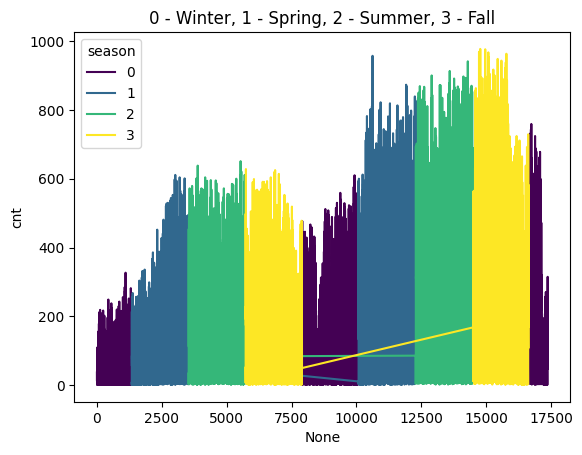

In [7]:
sns.lineplot(data=motorbike_df, x=motorbike_df.index, y="cnt", hue="season", palette="viridis").set_title("0 - Winter, 1 - Spring, 2 - Summer, 3 - Fall")

In year 2012 there are a lot of days with ambulance calls in a range from **700 up to 950**. This is much more than 2011. And some days that have a lot of calls in spring in 2012, looks like something happened there.

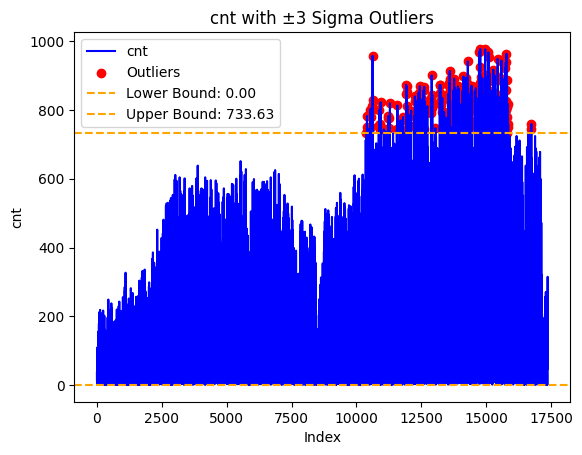

In [ ]:
mean_cnt = motorbike_df["cnt"].mean()
std_cnt = motorbike_df["cnt"].std()

lower_bound = max(0, mean_cnt - 3 * std_cnt)
upper_bound = mean_cnt + 3 * std_cnt

outliers = motorbike_df[(motorbike_df["cnt"] < lower_bound) | (motorbike_df["cnt"] > upper_bound)]

plt.plot(motorbike_df.index, motorbike_df["cnt"], label="cnt", color='blue')

plt.scatter(outliers.index, outliers["cnt"], color='red', label='Outliers')

plt.axhline(y=lower_bound, color='orange', linestyle='--', label=f"Lower Bound: {lower_bound:.2f}")
plt.axhline(y=upper_bound, color='orange', linestyle='--', label=f"Upper Bound: {upper_bound:.2f}")

plt.xlabel("Index")
plt.ylabel("cnt")
plt.title("cnt with ±3 Sigma Outliers")
plt.legend()

3 Sigma plot also proves my point.

## Model Training

In [9]:
X = motorbike_df[['cnt']].values

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
lof_predictions = lof.fit_predict(X)

iso_forest = IsolationForest(contamination=0.1, random_state=42)
iso_predictions = iso_forest.fit_predict(X)

lof_anomalies = np.where(lof_predictions == -1)[0]

iso_anomalies = np.where(iso_predictions == -1)[0]

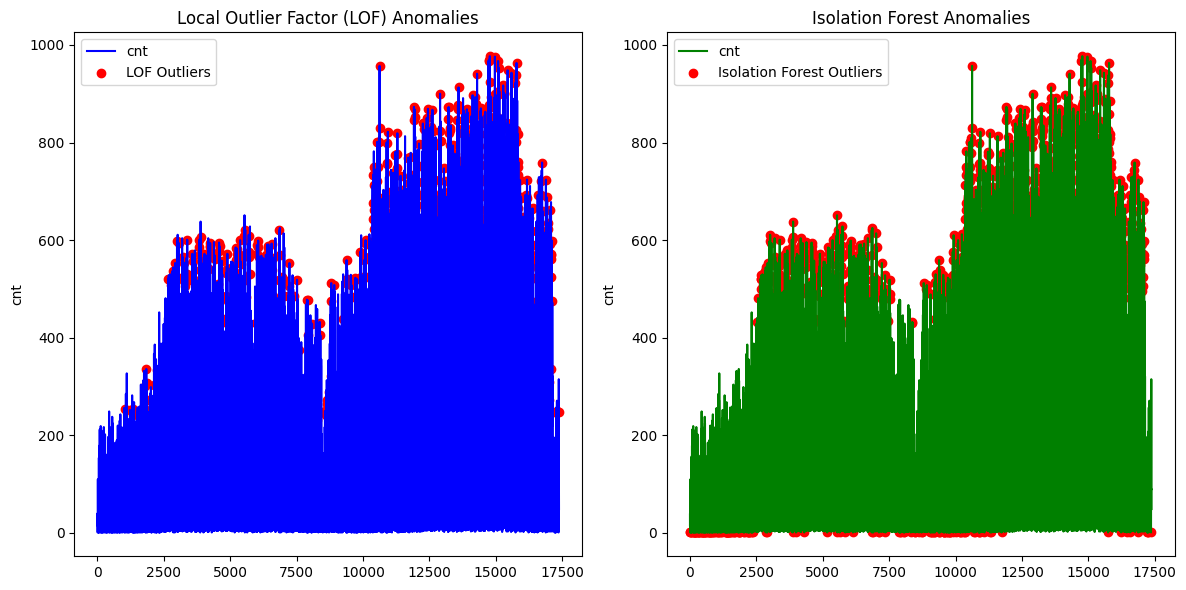

LOF Anomalies: [ 1055  1229  1321 ... 17110 17299 17369]
Isolation Forest Anomalies: [    4     5    30 ... 17237 17262 17358]


In [10]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(motorbike_df.index, motorbike_df['cnt'], label="cnt", color='blue')
plt.scatter(motorbike_df.iloc[lof_anomalies].index, motorbike_df.iloc[lof_anomalies]['cnt'], color='red', label='LOF Outliers')
plt.title('Local Outlier Factor (LOF) Anomalies')
plt.ylabel('cnt')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(motorbike_df.index, motorbike_df['cnt'], label="cnt", color='green')
plt.scatter(motorbike_df.iloc[iso_anomalies].index, motorbike_df.iloc[iso_anomalies]['cnt'], color='red', label='Isolation Forest Outliers')
plt.title('Isolation Forest Anomalies')
plt.ylabel('cnt')
plt.legend()

plt.tight_layout()
plt.show()

print("LOF Anomalies:", lof_anomalies)
print("Isolation Forest Anomalies:", iso_anomalies)

In [11]:
anomalies_df = motorbike_df.iloc[iso_anomalies]
anomalies_df

,index,date,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,day_night
4,5,2011-01-01,0,0,1,4,0,6,0,1,0.24,0.75,0.0000,1,0
5,6,2011-01-01,0,0,1,5,0,6,0,2,0.24,0.75,0.0896,1,0
30,31,2011-01-02,0,0,1,7,0,0,0,2,0.40,0.76,0.1940,1,1
49,50,2011-01-03,0,0,1,4,0,1,1,1,0.16,0.47,0.3881,1,0
71,72,2011-01-04,0,0,1,2,0,2,1,1,0.14,0.63,0.1343,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17101,17102,2012-12-20,0,1,12,8,0,4,1,2,0.30,0.70,0.0000,599,1
17215,17216,2012-12-25,0,1,12,4,1,2,0,2,0.24,0.87,0.0896,1,0
17237,17238,2012-12-26,0,1,12,2,0,3,1,2,0.26,0.65,0.2985,1,0
17262,17263,2012-12-27,0,1,12,3,0,4,1,2,0.24,0.87,0.2239,1,0


In [12]:
anomalies_df.to_csv("output/anomalies_motorbike.csv", index=False)